<h1> Advantage Actor Critic on continuous actions </h1>


<h3> Import dependencies </h3>

In [1]:
import copy
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import gymnasium
from tqdm import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import torch
from torch import nn
import cloudpickle
torch.set_grad_enabled(True) 

<h3> Implementation of A2C </h3>

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.critic = nn.Sequential(nn.Linear(2,128), nn.Dropout(),
                  nn.ReLU(),
                  nn.Linear(128,1))
        self.actor = nn.Sequential(nn.Linear(2,128), nn.Dropout(),
                  nn.ReLU(),
                  nn.Linear(128,2))
    
    def forward(self,state):
        v = self.critic(state)
        mu,sigma = self.actor(state)
        #sigma = torch.clamp(sigma,min=-2,max=20)
        sigma = torch.exp(sigma)
        return v,mu,sigma

    def load(self):
        with (open("./models/actor.pkl","rb") as f1, 
              open("./models/critic.pkl","rb") as f2):
            self.actor = cloudpickle.load(f1)
            self.critic = cloudpickle.load(f2)
    
    def dump(self):
        with (open("./models/actor.pkl","wb") as f1, 
              open("./models/critic.pkl","wb") as f2):
            cloudpickle.dump(self.actor,f1)
            cloudpickle.dump(self.critic,f2)

In [ ]:
def init_figs_axes():
    
    fig,(ax1,ax2) = plt.subplots(1,2)
    
    fig.tight_layout(pad=5.0)
    fig.set_figwidth(20)
    fig.set_figheight(8)
    
    ax1.set_title("Mean Return")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Mean Return")
    
    ax2.set_title("Mean Episode Length")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Mean Episode Length")
    
    return fig,ax1,ax2

In [ ]:
def plot_graphs(fig:Figure,ax1:Axes,ax2:Axes,y1,y2,y3,y4):

    ax1.cla()
    ax2.cla()
    
    ax1.plot(y1)
    ax1.plot(y2)
    ax2.plot(y3)
    ax2.plot(y4)
    
    display.display(fig)
    display.clear_output(wait=True)

In [ ]:
def compute_returns(rewards:List,gamma:float):
    
    returns = []
    ret = 0.
    
    for reward in reversed(rewards):
        ret = reward + gamma * ret
        returns.insert(0,ret)
        
    return returns

In [30]:
def critic_loss(returns:List,values:List,critic_loss_fn):
    
    returns = torch.tensor(returns).detach()
    values = torch.tensor(values)
    
    loss = critic_loss_fn(returns,values)
    
    return loss

In [31]:
def actor_loss(returns:List,values:List,log_probs:List):
    
    returns = torch.tensor(returns).detach()
    values = torch.tensor(values).detach()
    log_probs = torch.tensor(log_probs)
    
    loss = - ((returns - values) * log_probs).mean()
    
    return loss

In [ ]:
def update_agent(a2c:ActorCritic,rewards:List,values:List,log_probs:List,gamma:float,optimiser:torch.optim.Optimizer,critic_loss_fn):
    
    a2c.train()
    
    returns = compute_returns(rewards,gamma)
    
    critic_loss = critic_loss(returns,values,critic_loss_fn)
    actor_loss = actor_loss(returns,values,log_probs)
    
    loss = actor_loss + critic_loss
    
    optimiser.zero_grad()
    
    loss.backward()
    
    optimiser.step()

In [ ]:
def train_one_episode(env:gymnasium.Env,seed:int,optimiser:torch.optim.Optimizer,a2c:ActorCritic,gamma:float,critic_loss_fn):
    
    log_probs = []
    values = []
    rewards = []
    
    state,*_ = env.reset(seed=seed)
    state = torch.FloatTensor(state)
    
    while True:
        
        value,mu,sigma = a2c(state)
        
        dist = torch.distributions.Normal(mu,sigma)
        
        action = dist.sample()
        
        #action = torch.clamp(action,env.action_space.low[0],env.action_space.high[0])
                
        next_state,reward,terminated,truncated,*_ = env.step(action)
        
        action = torch.FloatTensor(action)
        next_state = torch.FloatTensor(next_state)
        
        log_prob = dist.log_prob(action)
        
        log_probs.append(log_prob)
        rewards.append(reward)
        values.append(value)
        
        state = next_state
        
        if terminated or truncated:
            break
    
    update_agent(a2c,rewards,values,log_probs,gamma,optimiser,critic_loss_fn)
    
    return rewards


In [ ]:
def evaluate_one_episode(a2c:ActorCritic,env:gymnasium.Env,seed:int):
    
    state,*_ = env.reset(seed=seed)
    
    rewards = []
    
    while True:
        
        value,mu,sigma = a2c(state)
                
        action = mu.item()
                
        next_state,reward,terminated,truncated,*_ = env.step(action)
        
        rewards.append(reward)
    
        if terminated or terminated:
            break
            
        state = next_state
    
    return rewards

In [5]:
NUM_EPISODES = 1
ALPHA = 0.1
GAMMA = 1
SEED = 10
ROLLING_AVERAGE_SIZE = 25

env = gymnasium.make("MountainCarContinuous-v0")
loss = nn.MSELoss()
a2c = ActorCritic()
optimiser = torch.optim.AdamW(a2c.parameters(),lr=ALPHA)
fig,ax1,ax2 = init_figs_axes()

train_returns = []
train_ep_lens = []
test_returns = []
test_ep_lens = []

for j in range(NUM_EPISODES):
  
  ret1 = train_one_episode(env,SEED,optimiser,a2c,GAMMA,loss)
  
  ret2 = evaluate_one_episode(a2c,env,SEED+1)
  
  train_returns.append(ret1)
  test_returns.append(ret2)
  train_ep_lens.append(ep_len1)
  test_ep_lens.append(ep_len2)
  
  
        

KeyboardInterrupt: 

In [ ]:
fig:Figure
ax1:Axes
ax2:Axes
ax3:Axes
ax4:Axes
ax5:Axes
ax6:Axes
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2)
fig.set_figwidth(20)
fig.set_figheight(20)
fig.tight_layout(pad=5.0)
ax1.plot(returns[:j])
ax1.set_ylabel(f"Mean return {NUM_TRIALS} trials")
ax1.set_xlabel("Episode")
ax1.set_title("Mean Return")
ax2.plot(ep_lens[:j])
ax2.set_ylabel(f"Mean episode length {NUM_TRIALS} trials")
ax2.set_xlabel("Episode")
ax2.set_title("Mean Episode Length")
ax3.plot(grads[0])
ax3.set_ylabel(f"Grad Norm")
ax3.set_xlabel("Grad Index")
ax3.set_title("Critic Grad Norm")
ax4.plot(losses[0])
ax4.set_ylabel(f"Loss")
ax4.set_xlabel("Loss Index")
ax4.set_title("Critic Loss")
ax5.plot(grads[1])
ax5.set_ylabel(f"Grad Norm")
ax5.set_xlabel("Grad Index")
ax5.set_title("Actor Grad Norm")
ax6.plot(losses[1])
ax6.set_ylabel(f"Loss")
ax6.set_xlabel("Loss Index")
ax6.set_title("Actor Loss");
ax7.plot(entropies)
ax7.set_ylabel(f"Entropy")
ax7.set_xlabel("Index")
ax7.set_title("Entropy Loss");
ax8.plot(rewards)
ax8.set_ylabel(f"Rewards")
ax8.set_xlabel("Index")
ax8.set_title("Rewards");

<h3> Evaluate in human render mode </h3>

In [ ]:
a2c = ActorCritic()
a2c.load()
env = gymnasium.make("MountainCarContinuous-v0",render_mode="human")
for _ in range(10):
    evaluate_one_episode(a2c,env,_+1)

KeyboardInterrupt: 

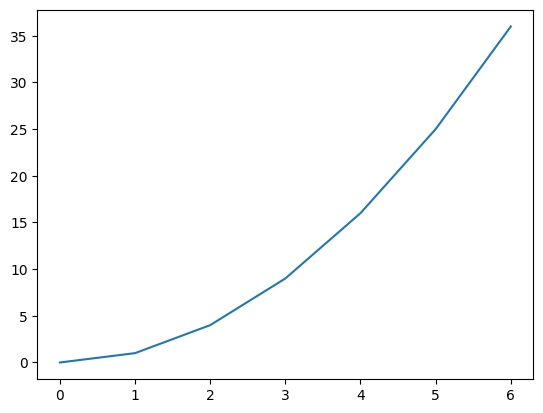

In [24]:
import matplotlib.pylab as plt
import numpy as np
import time
from IPython import display
%matplotlib inline

y = []
fig,ax = plt.subplots()
for i in range(100):
    try:
        print("At iter ",i)
        x = np.arange(0,i+1)
        y.append(x[-1]**2)
        ax.cla()
        ax.plot(x,y)
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(1)
    except Exception:
        break